# Case Study: Stock Price Prediction - Francisco Colella


In [1]:
import pandas as pd
import numpy as np
import math
import datetime
import time
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Data Exploration


In [2]:
df=pd.read_csv("^NSEI.csv")
df['Date'] = df['Date'].apply(pd.to_datetime)
df.drop(['Volume'],axis=1,inplace=True)
df.set_index('Date',inplace=True)
df.head()

Open         High          Low        Close    Adj Close
Date                                                                       
2007-09-17  4518.450195  4549.049805  4482.850098  4494.649902  4494.649902
2007-09-18  4494.100098  4551.799805  4481.549805  4546.200195  4546.200195
2007-09-19  4550.250000  4739.000000  4550.250000  4732.350098  4732.350098
2007-09-20  4734.850098  4760.850098  4721.149902  4747.549805  4747.549805
2007-09-21  4752.950195  4855.700195  4733.700195  4837.549805  4837.549805

Since 'Adj Close' and 'Close' are exactly the same in this data, we arbitrarily choose 'Close' price as variable to forecast. The following graph shows the evolution of the stock price. The vertical dashed line shows the division between train and test sample.

C:\Users\Francisco\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


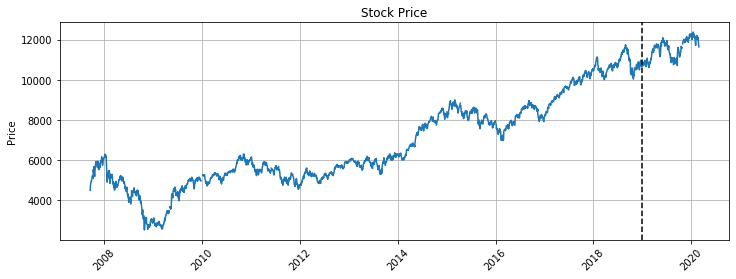

In [3]:
plt.figure(figsize=(12,4))
plt.plot(df['Close'])
plt.grid()
plt.title('Stock Price')
plt.ylabel('Price')
plt.axvline(x=pd.Timestamp(2019,1,1),color = 'black',linestyle='--')
plt.xticks(rotation=45)
plt.show()

### New Features

In this section, several features are created. These new featatures will be used as explanatory variables in the models. The following features are included:
- 3-day moving average for Close Price ('Prev_Price')
- Volatilty in previous 3 days ('3Vol')
- Percentange change between Open and Adj Close prices in previous day ('Open_Close')
- Percentange change between High and Low prices in previous day ('High_Low')


All the features are shifted one day ahead. In this way, the option price in $t$ is predicted with data available up to $t-1$. Also, the first three observations that are lost because of the moving averages are dropped from the dataframe.


In [4]:
df['Prev_Price'] = df['Close'].shift(1).rolling(3).mean()
df['Open_Close'] = ((df['Close']-df['Open'])/df['Open']).shift(1)
df['High_Low'] = ((df['High']-df['Low'])/df['Low']).shift(1)
df['3Vol'] = df['Close'].shift(1).rolling(3).std()

df.dropna(inplace=True)
df = df[['Close','Prev_Price','3Vol','Open_Close','High_Low']]
df.head()

Close   Prev_Price        3Vol  Open_Close  High_Low
Date                                                                  
2007-09-20  4747.549805  4591.066732  125.040395    0.040020  0.041481
2007-09-21  4837.549805  4675.366699  112.119343    0.002682  0.008409
2007-09-24  4932.200195  4772.483236   56.859490    0.017799  0.025773
2007-09-25  4938.850098  4839.099935   92.334954    0.019650  0.021500
2007-09-26  4940.500000  4902.866699   56.663726   -0.000051  0.015528

The following plots show the correlation between the dependent variable and each of the regresors considered. There is a clear positive correlation between 'Close' and 'Prev_Price'.

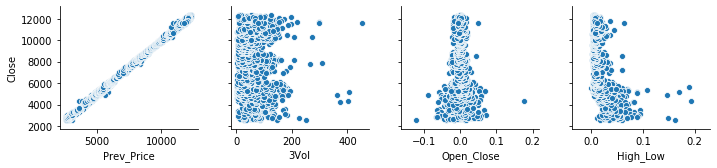

In [5]:
sns.pairplot(df,y_vars='Close',x_vars=['Prev_Price','3Vol','Open_Close','High_Low'])
plt.show()

### Train - Test Split

The Dataset is splitted into train and test set. The former contains the observations to estimate the models, while the latter will be used to evaluate its performance on an independent set. In addittion, we separate the independent variable (Close) from the predictors to train the model and generate the predicted values

In [6]:
y = df['Close']
x = df.drop(['Close'], axis=1)

df_train = df[df.index<pd.Timestamp(2019,1,1)]
df_test = df[df.index>pd.Timestamp(2019,1,1)]

y_train = df_train['Close']
y_test = df_test['Close']
x_train = df_train.drop(['Close'], axis=1)
x_test = df_test.drop(['Close'], axis=1)

##  Models

The algorithms of Linnear Regression, K-Nearest Neighbours and Random forest are considered for this case study. The three models will be used to provide the stock price using data from the past as inputs.

### Linear Regression Model

The Linear Regression Model is a procedure by which attempts to model the relationship between the dependent variable and the regresors fitting a linear equation to the data. The estimated coefficients will then be used to create the predicted values for the stock price given the independent variables.

In [7]:
X_train = sm.add_constant(x_train)

linreg = sm.OLS(y_train,X_train).fit()
linreg.summary()

C:\Users\Francisco\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 4.117e+05
Date:                Wed, 16 Sep 2020   Prob (F-statistic):               0.00
Time:                        17:28:58   Log-Likelihood:                -15727.
No. Observations:                2676   AIC:                         3.146e+04
Df Residuals:                    2671   BIC:                         3.149e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.6438      7.518      2.214      0.027       1.903      31.385
Prev_Price     0.9995      0.001   1079.207      0.000       0.998       1.001
3Vol           0.0181      0.056      0.324      0.746      -0.092       0.128
Open_Close  3555.8439    125.739     28.280      0.000    3309.288    3802.400
High_Low    -492.2044    167.911     -2.931      0.003    -821.452    -162.957
==============================================================================
Omnibus:                      240.849   Durbin-Watson:                   1.572
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1180.346
Skew:                          -0.284   Prob(JB):                    4.91e-257
Kurtosis:                       6.204   Cond. No.                     7.21e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.21e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The predicted stock prices by the linear regression model specified above in the test set are built in the following cell.

In [8]:
y_linreg = linreg.predict(sm.add_constant(x_test))

### KNN

In this section, the K-Nearest Neighbours algorithm is emplaced. In order to chose the hyperparameter K, which stands for the number of "neighbours" the algorithm takes into consideration for averaging observations and making predictions, the Root MSE in the test sample is compared for different specifications of K.

In [9]:
neighbours = np.arange(1,15) #Grid for K

start = time.time()
for k in neighbours:
    
    train_index = x_train.index[k:]
    # Given K, the model is re-trained for each day, so as to use all the information available up to the previous date.
    # The same procedure is used in random forest.
    for date in train_index:
        x_train_knn_calib = x_train[df_train.index<date]
        y_train_knn_calib = y_train[df_train.index<date]
        knn_calib = KNeighborsRegressor(n_neighbors=k).fit(x_train_knn_calib, y_train_knn_calib)
        
        if date == train_index[0]:
            y_knn_calib = np.array(knn_calib.predict(x_train[x_train.index==date]))
        else:
            y_knn_calib = np.append(y_knn_calib,knn_calib.predict(x_train[x_train.index==date]))  
    if k == neighbours[0]:
        mse_knn_calib = np.array(mean_squared_error(y_train[k:],y_knn_calib))
    else:
        mse_knn_calib = np.append(mse_knn_calib,mean_squared_error(y_train[k:],y_knn_calib))           
end = time.time()
print(f'Time elapsed (minutes) = {round((end-start)/60,2)}')

Time elapsed (minutes) = 2.36


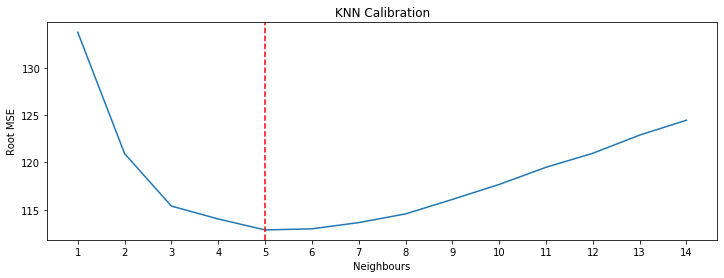

In [10]:
plt.figure(figsize=(12,4))        
plt.plot(neighbours,np.sqrt(mse_knn_calib))
plt.title('KNN Calibration')
plt.xlabel('Neighbours')
plt.xticks(np.arange(min(neighbours), max(neighbours)+1, 1.0))
plt.axvline(x = int(neighbours[mse_knn_calib==min(mse_knn_calib)]),linestyle = '--',color = 'red')
plt.ylabel('Root MSE')
plt.show()

In [11]:
k_star = int(neighbours[mse_knn_calib==min(mse_knn_calib)])
print(f'K parameter = {k_star}')

K parameter = 5


Once the parameter K is optimized, we proceed to create the predicted values over the test sample.

In [12]:
for date in x_test.index:
    x_train_knn_f = x[df.index<date]
    y_train_knn_f = y[df.index<date]
    knn_f = KNeighborsRegressor(n_neighbors=k_star).fit(x_train_knn_f, y_train_knn_f)
    if date == x_test.index[0]:
        y_knn = np.array(knn_f.predict(x_test[x_test.index==date]))
    else:
        y_knn = np.append(y_knn,knn_f.predict(x_test[x_test.index==date]))  

### Random Forest

Random Forest is an ensamble-tree model considered a very powerfull tool for prediction in Machine Learning. For the sake of simplicity, only two hyperparameters will be determined by cross-validation using Root MSE in the test sample: n_estimators and max_depth. The following cell takes approximately three hours to run.

In [13]:
n_grid = np.array([5,10,25,50,100,200])
max_depth = np.array([5,10,15,20])

mse_rf_calib = np.array([])
start = time.time()

train_index_rf = x_train.index[5:]

for n in n_grid:
    for d in max_depth:
        for date in train_index_rf:
            x_train_rf_calib = x[df.index<date]
            y_train_rf_calib = y[df.index<date]
            rf_calib = RandomForestRegressor(n_estimators =n, max_depth=d, random_state=0).fit(x_train_rf_calib, y_train_rf_calib)
            if date == train_index_rf[0]:
                y_rf_calib = np.array(rf_calib.predict(x_train[x_train.index==date]))
            else:
                y_rf_calib = np.append(y_rf_calib,rf_calib.predict(x_train[x_train.index==date]))

        mse_rf_calib = np.append(mse_rf_calib,mean_squared_error(y_train[5:],y_rf_calib))
end = time.time()
print(f'Time elapsed (minutes) = {round((end-start)/60,2)}')

Time elapsed (minutes) = 250.66


In [14]:
rf_calib_df = pd.DataFrame()
rf_calib_df['n_estimators'] = np.repeat(n_grid,repeats=len(max_depth))
rf_calib_df['max_depth'] = np.array(list(max_depth)*len(n_grid))
rf_calib_df['RMSE'] = np.sqrt(mse_rf_calib)

rf_calib_df.head(10)

n_estimators  max_depth        RMSE
0             5          5  116.827943
1             5         10  107.875300
2             5         15  108.476860
3             5         20  108.730379
4            10          5  114.987505
5            10         10  104.849690
6            10         15  105.061387
7            10         20  105.320221
8            25          5  114.317345
9            25         10  102.288167

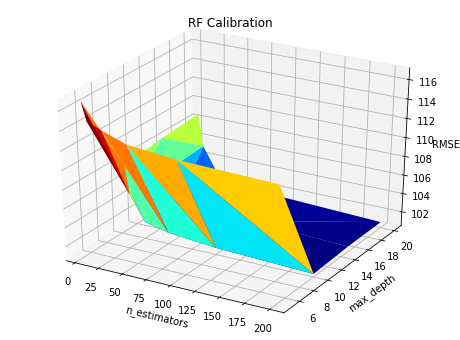

In [15]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
ax.plot_trisurf(rf_calib_df['n_estimators'], rf_calib_df['max_depth'],rf_calib_df['RMSE'], cmap=cm.jet, linewidth=0.2)
plt.title('RF Calibration')
ax.set(xlabel='n_estimators', ylabel='max_depth', zlabel='RMSE')
plt.show()

In [16]:
n_estimators_star = int(rf_calib_df.n_estimators[rf_calib_df['RMSE']==min(rf_calib_df['RMSE'])])
max_depth_star = int(rf_calib_df.max_depth[rf_calib_df['RMSE']==min(rf_calib_df['RMSE'])])
print(f'n_estimators= {n_estimators_star}\nmax_depth = {max_depth_star}')

n_estimators= 200
max_depth = 10


Once both hyperparameters are determined, the random forest algorithm is trained properly and used to forecast the stock price in the test sample.

In [17]:
for date in x_test.index:
    x_train_rf_f = x[df.index<date]
    y_train_rf_f = y[df.index<date]
    rf_f = RandomForestRegressor(n_estimators =n_estimators_star, max_depth=max_depth_star, random_state=0).fit(x_train_rf_f, y_train_rf_f)
    if date == x_test.index[0]:
        y_rf = np.array(rf_f.predict(x_test[x_test.index==date]))
    else:
        y_rf = np.append(y_rf,rf_f.predict(x_test[x_test.index==date]))  

# Models comparison

The following graph shows the actual stock price in the test sample together with the predicted prices by the three algorithms considered. Overall, the performance seems acceptable for the three models. 
The linear regression model achieves the lowest root mean squared error among the three algorithms.  

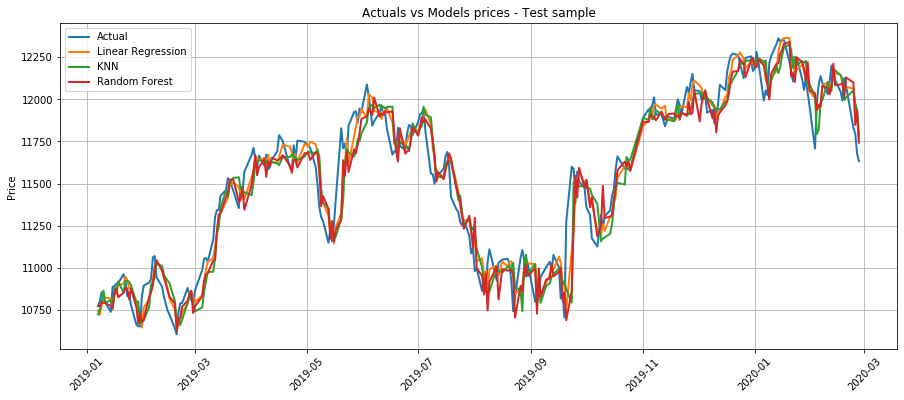

In [18]:
plt.figure(figsize=(15,6))
plt.plot(df_test.index,y_test,linewidth=2)
plt.plot(df_test.index,y_linreg,linewidth=2)
plt.plot(df_test.index,y_knn,linewidth=2)
plt.plot(df_test.index,y_rf,linewidth=2)
plt.title('Actuals vs Models prices - Test sample')
plt.ylabel('Price')
plt.grid()
plt.xticks(rotation=45)
plt.legend(['Actual','Linear Regression','KNN','Random Forest'])
plt.show()

In [19]:
mse_linreg = mean_squared_error(y_test,y_linreg)
mse_knn = mean_squared_error(y_test,y_knn)
mse_rf = mean_squared_error(y_test,y_rf)

print(f'RMSE Linear Regression = {round(math.sqrt(mse_linreg),2)}\nRMSE KNN = {round(math.sqrt(mse_knn),2)} \nRMSE Random Forest = {round(math.sqrt(mse_rf),2)}')

RMSE Linear Regression = 117.24
RMSE KNN = 140.14 
RMSE Random Forest = 134.36
